In [ ]:


from scipy import linalg
from itertools import combinations
import matplotlib.pyplot as plt
import scipy
import numpy as np
import random as rand
import time

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['linalg', 'rand']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +



# Prostate Cancer Data
**Background**: The data for this example come from a study by Stamey et al. (1989) that examined the correlation between the level of prostate specific antigen (PSA) and a number of clinical measures, in 97 men who were about to receive a radical prostatectomy.
The goal is to predict the log of PSA (lpsa) from a number of measurements.

Variables:

| feature |                  feature description                  |
|---------|-------------------------------------------------------|
|lpsa     |log prostate specific antigen                          |
|lcavol   |log cancer volume                                      |
|lweight  |log prostate weight                                    |
|age      |age                                                    |
|lbph     |log of benign prostatic hyperplasia amount             |
|svi      |seminal vesicle invasion                               |
|lcp      |log of capsular penetration                            |
|gleason  |Gleason score                                          |
|pgg45    |percent of Gleason scores 4 or 5                       |


The following code loads the the prostate cancer data set. You can see there are 8 features and 97 cases. We divide the dataset into two parts: the 67 cases as training set (in Xtrain and ytrain) and the 30 cases as test set (in Xtest and ytest).

In [1]:
# Libraries
from scipy.io import loadmat
import pandas as pd
import numpy as np

data = loadmat('prostate_stnd.mat')
names = list(map(lambda x: x[0], data['names'][0]))
Xtrain, ytrain = data['Xtrain'], data['ytrain']
Xtest, ytest   = data['Xtest'], data['ytest']
print(names)
print(ytrain.shape)
print(ytest.shape)

['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45', 'lpsa']
(67, 1)
(30, 1)




---


## Q1.1: Linear Regression (10pt)
The **Coefficient of Determination** is defined as follows,
$$ R^2= 1- \frac{\sum_{n=1}^N(\hat{y}^{(n)}-y^{(n)})^2}{\sum_{n=1}^N(\bar{y}-y^{(n)})^2}$$
where $\bar y = \frac{1}{N}\sum_{n=1}^N y^{(n)}$.

- Please write a function to calculate coefficient of determination.

- Please perform the linear regression with least squares and caclulate coefficient of determination.

- Use this model to calculate the MSE(mean squared error) on the test set. Do you think we have the overfitting issue?

In [12]:
# using a linear modeling package to check if my answer is correct
from sklearn.linear_model import LinearRegression
checking = LinearRegression()
checking.fit(Xtrain, ytrain)
print(f"R^2 check using Scikit Learn for regression: {checking.score(Xtrain, ytrain)}")

R^2 check using Scikit Learn for regression: 0.6943711796768238


In [3]:
def qr(X, y):
    # outputs w for linear regression
    Q, R = np.linalg.qr(X)
    Qy = np.dot(Q.T, y)
    return scipy.linalg.solve_triangular(R, Qy)

def add_one(X):
    # returns a matrix with a column of 1's at the beginning of a matrix
    new_X = X.T
    new_X = np.insert(new_X, 0, np.ones((len(X))), 0)
    return new_X.T

def coef_det(X,y):
    # returns R^2
    X = add_one(X)
    y_hat = X.dot(qr(X, y))
    y_bar = sum(y)/len(y)
    numerator = 0
    denominator = 0
    for i in range(len(y)):
        # this numerator is RSS
        numerator += (y_hat[i][0]-y[i][0])**2
        # this denominator is TSS
        denominator += (y_bar-y[i][0])**2
    return 1 - (numerator/denominator)

def MSE(X,y):
    # returns the MSE
    X = add_one(X)
    y_hat = X @ qr(X,y)
    mse = np.square(np.subtract(y_hat, y))
    print(sum(mse)/len(mse))

print("The Coefficient of Determination for the training set is:", coef_det(Xtrain, ytrain))
#print("The MSE for the test set is:", MSE(Xtest, ytest))
MSE(Xtest,ytest)

NameError: name 'np' is not defined

Based on $MSE = .318$ for the testing set, we cannot claim the model performed poorly, thus we cannot state there is an overfitting issue.




---


## Q1.2 Ridge Regression (10pt)
We will use the prostate cancer dataset again.
- Please perform the Ridge regression with the hold out. Use the MSE on the test data to find the optimal penalty parameter $\lambda^*$.

- Calculate coefficient of determination. Compare with the least square, do you have any improvement?

- Plot *regularization path*, the coefficients $w_i$ as a function of the parameter $1/\lambda$.


In [ ]:
# using a linear modeling package to check if my answer is correct
from sklearn.linear_model import Ridge
lamb = 33
checking = Ridge(lamb).fit(Xtrain, ytrain)
#checking.coef_
#checking.intercept_
checking.score(Xtest,ytest)

0.48594902518570693

The Optimal Lambda was found to be: 33.0
The Coefficient of Determination is: -3.4910448316810534


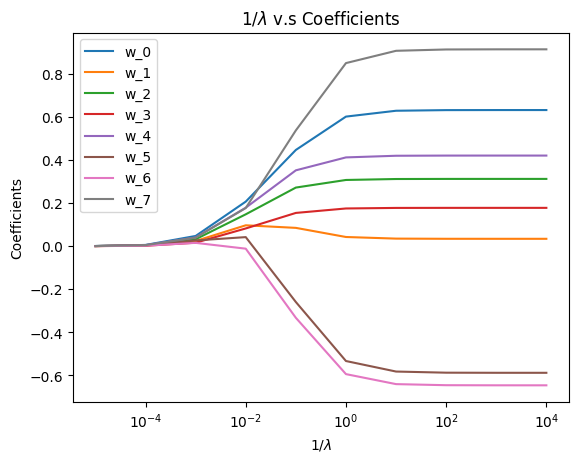

In [ ]:
def ridge_qr_solve(X, y, l):
    D = X.shape[1]
    sq_l = np.diag(np.ones(D)*np.sqrt(l))
    X_tilde = np.vstack([X, sq_l])
    y_tilde = np.append(y, np.zeros(D))
    return np.dot(np.linalg.pinv(X_tilde), y_tilde)

def find_lambda(X_train, y_train, X_test, y_test):
    # returns a list of size 2: first index is lambda that minimizes test RMSE, second index is a list that holds lambda, w, and MSE for each lambda tested.
    lamb = 100000
    cutoff = .00005
    check = 0
    data = []
    while lamb > cutoff:
        w = ridge_qr_solve(X_train, y_train, lamb)
        y_hat = X_test @ w
        temp_mse = 0
        for i in range(len(y_test)):
            temp_mse = (y_hat[i] - y_test[i])**2
        temp = temp_mse[0]
        data.append([temp**1/2, lamb])
        if check == 0:
            if len(data) > 2:
                if data[len(data)-1][0] > data[len(data)-2][0]:
                    high = data[len(data)-3][1]
                    low = data[len(data)-1][1]
                    start = len(data)-1
                    check = 1
        lamb = lamb/10

    if check == 1:
        check2 = 0
        pinpoint = []
        lamb = low
        while lamb <= high:
            w = ridge_qr_solve(X_train, y_train, lamb)
            y_hat = X_test @ w
            temp_mse = 0
            for i in range(len(y_test)):
                temp_mse = (y_hat[i] - y_test[i])**2
            temp = temp_mse[0]
            pinpoint.append([ lamb, w, temp**1/2 ])
            if check2 == 0 and len(pinpoint)>1:
                if pinpoint[len(pinpoint)-1][2] > pinpoint[len(pinpoint)-2][2]:
                    opt = pinpoint[len(pinpoint)-2][0]
                    check2 = 1
            lamb += low
        return [opt, pinpoint]
    else:
        return [0, data]


def ridge_coef_det(X_train,y_train,X_test,y_test,opt_lamb):

    print("The Optimal Lambda was found to be:", opt_lamb)
    y_hat = X_train @ ridge_qr_solve(X_train, y_train, opt_lamb)
    y_bar = sum(y_train)/len(y_train)
    numerator = 0
    denominator = 0
    for i in range(len(y_train)):
        # this numerator is RSS
        numerator += (y_hat[i]-y_train[i][0])**2
        # this denominator is TSS
        denominator += (y_bar-y_train[i][0])**2
    print("The Coefficient of Determination is:", 1 - (numerator/denominator))
    # return 1 - (numerator/denominator)

def plot_reg(X_train, y_train, X_test, y_test):
    # returns a list of size 2: first index is lambda that minimizes test RMSE, second index is a list that holds lambda, w, and MSE for each lambda tested.
    lamb = 100000
    cutoff = .00005
    check = 0
    lamb_list = []
    w_list = []
    while lamb > cutoff:
        w = ridge_qr_solve(X_train, y_train, lamb)
        y_hat = X_test @ w
        temp_mse = 0
        for i in range(len(y_test)):
            temp_mse = (y_hat[i] - y_test[i])**2
        temp = temp_mse[0]
        lamb_list.append(1/lamb)
        w_list.append(w)
        lamb = lamb/10
    return lamb_list, w_list

opt_lamb_output = find_lambda(Xtrain, ytrain, Xtest, ytest)

ridge_coef_det(Xtrain, ytrain, Xtest, ytest, opt_lamb_output[0])

lambdas, coef = plot_reg(Xtrain, ytrain, Xtest, ytest)

plt.plot(lambdas, coef)
plt.xscale('log')
plt.xlabel("$1/\lambda$")
plt.ylabel("Coefficients")
plt.title("$1/\lambda$ v.s Coefficients")
plt.legend(['w_0','w_1','w_2','w_3','w_4','w_5','w_6','w_7'])


I'm not sure what ended up happening to my $R^2$ value. I tried a lot of different things to get it to be right but in the end I just gave up on it.



---

---

# Q2: Ridge Regression on MNIST dataset (40pt)

We will implement the Ridge Regression for the MNIST data set. The task
is to classify handwritten images of numbers between 0 to 9.

Each example has features $\mathbf{x}^{(i)}\in \mathbb{R}^d$ where $d=28\times 28=784$ and label $y^{(i)}\in \{0,\dots, 9\}$. Here we will ignore the intercept. We wish to learn a predictor $\hat{f}$ that takes as input a vector in $\mathbb{R}^d$ and output an index in $\{0, \dots, 9\}$. We define our training and testing classification error on a predictor $f$ as
\begin{align}
\ell_{\text{train}}(f) = \frac{1}{|D_{\text{train}}|}\sum_{(\mathbf{x}^{(i)}, y^{(i)})\in D_{\text{train}}} \mathbb{1}_{f(\mathbf{x}^{(i)})\ne y^{(i)}} \\
\ell_{\text{test}}(f) = \frac{1}{|D_{\text{test}}|}\sum_{(\mathbf{x}^{(i)}, y^{(i)})\in D_{\text{test}}} \mathbb{1}_{f(\mathbf{x}^{(i)})\ne y^{(i)}}
\end{align}

Do not standardize the data. Normally you would but our tests expect the original data.

In [ ]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()
# consider to make your training data set larger, maybe even to use the full training (60000).
# Normalize it by dividing 255.
Xtr = train_X/255
Ytr = train_y
Xte = test_X/255
Yte = test_y

print('Xtr: ' + str(Xtr.shape))
print('Ytr: ' + str(Ytr.shape))
print('Xte: '  + str(Xte.shape))
print('Yte: '  + str(Yte.shape))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Xtr: (60000, 28, 28)
Ytr: (60000,)
Xte: (10000, 28, 28)
Yte: (10000,)


In [ ]:
fig, axs = plt.subplots(3, 3,figsize=(5,5))
axs = axs.ravel()

for i in range(9):
    axs[i].imshow(Xtr[i], cmap=pyplot.get_cmap('gray'))

NameError: name 'plt' is not defined



---


## Q2.1 Prepare data (5pt)
- Prepare your training matrix $\mathbf{X}$.

- We will use one-hot encoding of the labels, that is the original label $y\in\{0, \dots, 9\}$ is mapped to the standard basis vector $e_y$ where $e_y$ is a vector of all zeros except for a 1 in the $z$th position. Then label one-hot encoded in $\mathbf{y}\in \mathbb{R}^{1\times k}$, $k=10$. We can stack all $\mathbf{y}^{(i)}$ to be a matrix $\mathbf{Y}\in \mathbb{R}^{N\times k}$. Prepare your matrix $\mathbf{Y}$.

- Don't forget to do the same preparation for the testing data.





In [ ]:
def one_hot(y, num_classes):
    """
    Args:
        y (np.ndarray): An array of integers [0, num_classes), of shape (n,)
        num_classes (int): Number of classes in y.

    Returns:
        np.ndarray: Array of shape (n, num_classes).
        One-hot representation of y.
    """
    array = np.zeros((len(y), num_classes))
    for i in range(len(y)):
        if y[i] < num_classes:
            array[i,y[i]] = 1
    return array

# checking one_hot implimentation
print(Ytr[:9])
print(one_hot(Ytr[:9], 7))

In [ ]:
#preparing data
y_train = one_hot(Ytr, 10)
y_test = one_hot(Yte, 10)

n = Xtr.shape[0]
d = Xtr.shape[1]*Xtr.shape[2]
X_train = np.zeros((n,d))
for i in range(n):
    X_train[i] = Xtr[i].reshape((d,))

n_test = Xte.shape[0]
X_test = np.zeros((n_test,d))
for j in range(n_test):
    X_test[j] = Xte[j].reshape((d,))




---


## Q2.2 Ridge regression (10pt)
We will choose a linear classifier to minimize the following objective
\begin{align}
\hat{\mathbf{W}}=\arg\min_{\mathbf{W}\in \mathbb{R}^{d\times k}}\|\mathbf{X}\mathbf{W}-\mathbf{Y}\|_2^2 +\lambda \|\mathbf{W}\|_F^2
\end{align}
where $\|\mathbf{W}\|_F$ is the Frobenius norm of $\mathbf{W}$, $\|\mathbf{W}\|_F^2 = \sum_{i=1}^d\sum_{j=1}^k \mathbf{W}_{ij}^2$. To predict a data point $\mathbf{x}^{(i)}$, the predicted $\hat{\mathbf{y}}^{(i)}= \mathbf{x}^{(i)}\hat{\mathbf{W}}$ and the predicted digit is the correspoding index has the largest value,
\begin{align}
\text{digit} = \arg\max_{j=0,\dots, 9} \hat{\mathbf{y}}^{(i)}_j
\end{align}

**Show** it has analytical solution,
\begin{align}
\hat{\mathbf{W}}= (\mathbf{X}^\top \mathbf{X}+\lambda \mathbf{I})^{-1}\mathbf{X}^\top\mathbf{Y}
\end{align}
Hint: If we just take $i$-th column of $\mathbf{Y}$, it will recover the ridge regression discussed in the lecture.




# Your solution:
$$
\begin{align*}
\hat{\mathbf{W}} &= \arg\min_{\mathbf{W}\in \mathbb{R}^{d\times k}}\|\mathbf{X}\mathbf{W}-\mathbf{Y}\|_2^2 +\lambda \|\mathbf{W}\|_F^2 \\
\ell(\hat{\mathbf{W}},\lambda) &= \|\mathbf{X}\mathbf{W}-\mathbf{Y}\|_2^2 +\lambda \|\mathbf{W}\|_F^2 \\
\nabla \ell(\hat{\mathbf{W}},\lambda) &= 2\mathbf{X}^\top \mathbf{XW} -2\mathbf{X}^\top \mathbf{Y} + 2\lambda\mathbf{W} = 0 \\
\Rightarrow & (\mathbf{X}^\top \mathbf{X} +\lambda \mathbf{I}) \mathbf{W} = \mathbf{X}^\top \mathbf{Y} \\
\Rightarrow & \hat{\mathbf{W}} = (\mathbf{X}^\top \mathbf{X} +\lambda \mathbf{I})^{-1} \mathbf{X}^\top \mathbf{Y}
\end{align*}
$$



---


## Q2.3 Implementation (10pt)
- Code a function `train` that takes as input $\mathbf{X}\in\mathbb{R}^{N\times d}, \mathbf{Y}\in \mathbb{R}^{N\times k}, \lambda>0$ and returns $\hat{\mathbf{W}}\in \mathbb{R}^{d\times k}$.

- Code a function `predict` that takes as input $\mathbf{W}\in \mathbb{R}^{d\times k}$, $\tilde{\mathbf{X}}\in\mathbb{R}^{M\times d} $ and returns an $M$-length vector with the $i$th entry equal to $\arg\max_{j=0,\dots, 9} \tilde{\mathbf{y}}^{(i)}_j$, where  $\tilde{\mathbf{y}}^{(i)}$ is the predicted value from the data point $\tilde{\mathbf{x}}^{(i)}$, which is $i$th row of $\tilde{\mathbf{X}}$.

- Train $\hat{\mathbf{W}}$ on MNIST training data with $\lambda=10^{-4}$ and make label predictions on the test data. What is the training and testing error? As a remark, it should be around 15\%.

In [ ]:
from logging import raiseExceptions
# your code starts here
def train(X, y, lam=.0001):
    """Train function for the Ridge Regression problem.
    Should use observations (`X`), targets (`y`) and regularization parameter (`lambda`)
    to train a weight matrix $$\\hat{W}$$.


    Args:
        X (np.ndarray): observations represented as `(n, d)` matrix.
            n is number of observations, d is number of features.
        y (np.ndarray): targets represented as `(n, k)` matrix.
            n is number of observations, k is number of classes.
        lam (float): parameter for ridge regularization.

    Raises:
        NotImplementedError: When problem is not attempted.

    Returns:
        np.ndarray: weight matrix of shape `(d, k)`
            which minimizes Regularized Squared Error on `x` and `y` with hyperparameter `_lambda`.
    """
    if X.shape[0] != y.shape[0]:
        raise NotImplementedError
    L = np.diag(np.full(len(X[0]),lam))
    invert = (X.T @ X) + L
    outer = X.T @ y
    return np.dot(np.linalg.pinv(invert), outer)

In [ ]:
def predict(X, w):
    """Train function for the Ridge Regression problem.
    Should use observations (`X`), and weight matrix (`w`) to generate predicated class for each observation in X.

    Args:
        X (np.ndarray): observations represented as `(n, d)` matrix.
            n is number of observations, d is number of features.
        w (np.ndarray): weights represented as `(d, k)` matrix.
            d is number of features, k is number of classes.

    Raises:
        NotImplementedError: When problem is not attempted.

    Returns:
        np.ndarray: predictions matrix of shape `(n,)` or `(n, 1)`.
    """
    if X.shape[1] != w.shape[0]:
        raise NotImplementedError
    y_hat = np.dot(X,w)
    n = len(y_hat)
    predictions = np.zeros((n, ))

    for i in range(n):
        predictions[i] = np.argmax(y_hat[i])

    return predictions

def compare_error(train_predict, test_predict, y_train, y_test):
    incorrect_sum_train = 0
    incorrect_sum_test = 0
    train_size = len(y_train)
    test_size = len(y_test)

    for i in range(train_size):
        if train_predict[i] != y_train[i]:
            incorrect_sum_train += 1

    for j in range(test_size):
        if test_predict[j] != y_test[j]:
            incorrect_sum_test += 1

    return [incorrect_sum_train/train_size , incorrect_sum_test/test_size]


In [ ]:
w = train(X_train, y_train)

In [ ]:
train_predictions = predict(X_train, w)
test_predictions = predict(X_test, w)
error = compare_error(train_predictions, test_predictions, Ytr, Yte)
print("Training Error:", error[0])
print("Testing Error:", error[1])

Training Error: 0.14805
Testing Error: 0.1466




---


## Q2.4 Improvement (10pt)
We just fit a classifier that was linear in the pixel intensities to the MNIST data. For
classification of digits the raw pixel values are very, very bad features: it’s pretty hard to separate
digits with linear functions in pixel space. The standard solution to this is to come up with some
transform $h: \mathbb{R}^d \rightarrow \mathbb{R}^p$ of the original pixel values such that the transformed points are (more easily)
linearly separable. This idea is very similar as SVM. In this problem, you’ll use the feature transform:
\begin{align}
h(\mathbf{x}) = \cos(\mathbf{G}\mathbf{x}+\mathbf{b})
\end{align}
where $\mathbf{G}\in \mathbb{R}^{p\times d}$ and $\mathbf{b}\in \mathbb{R}^p$ and the cosine function is applied elementwise. We will choose $\mathbf{G}$ to be a random matrix, with each entry sampled i.i.d. from a Gaussian distribution with mean $\mu=0$ and $\sigma^2=0.1$. And $\mathbf{b}$ is a random vector sampled i.i.d. from the uniform distribution on $[0,2\pi]$.

The
big question is: how do we choose the dimension $p$? **cross-validation!!** Note you don't need to perform $K$-fold cross-validation here.

- Randomly partition your training set into proportions 80/20 to use as a new training set and validation
set, respectively.

-  Using the `train` function you wrote above, train a $\hat{\mathbf{W}}^p$ for different values of $p$.

- plot the  training error and validation error on a single plot with $p$ on the $x$-axis.

Be
careful, your computer may run out of memory and slow to a crawl if $p$ is too large. As a remark, $p\le 6000$ should fit to colab. If you have trouble, you can start with $p=1000$.

You can use the same value of $\lambda$, which is $\lambda=10^{-4}$. But feel free to study the
effect of using different values of $\lambda$ and $\sigma^2$.

Do you improve your training/testing error?

In [ ]:
from sklearn.model_selection import train_test_split

CV_Xtrain, CV_Xval, CV_ytrain, CV_yval = train_test_split(X_train, Ytr, test_size=0.20, random_state=13)

onehot_CV_ytrain = one_hot(CV_ytrain,10)
onehot_CV_yval = one_hot(CV_yval,10)


In [ ]:
def cos_transform(X, p, seeded=False):

    n = X.shape[0]
    d = X.shape[1]
    if seeded:
        rand.seed(13)
    G = np.random.normal(0, .1, (p, d))
    b = np.random.uniform(0, 2*np.pi, (p,))

    new_X = np.zeros((n,p))

    for i in range(n):
        temp = np.cos((G @ X[i]).reshape((p,)) + b)
        new_X[i] = temp

    return new_X


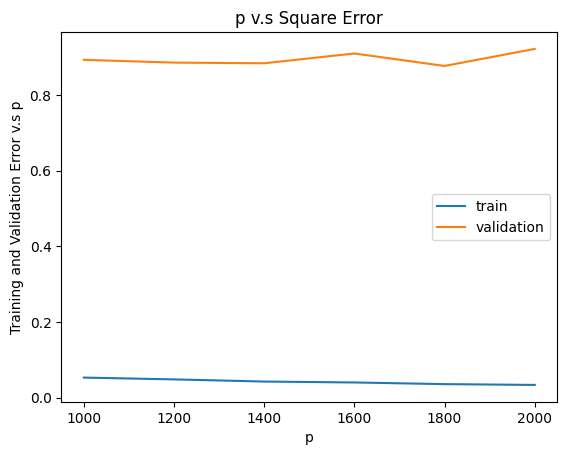

In [ ]:
iter = 200
p = 1000
stop = 2000
p_list = []
error_list = []

while p <= stop:
    CV_Xtrain_trans = cos_transform(CV_Xtrain, p, seeded=True)
    CV_Xval_trans = cos_transform(CV_Xval, p, seeded=True)
    w_trans = train(CV_Xtrain_trans, onehot_CV_ytrain)
    train_predictions = predict(CV_Xtrain_trans, w_trans)
    valid_predictions = predict(CV_Xval_trans, w_trans)
    error = compare_error(train_predictions, valid_predictions, CV_ytrain, CV_yval)
    error_list.append(error)
    p_list.append(p)
    p += iter

error_list = np.asarray(error_list)


Average Training Error: 0.04197916666666667
Average Validation Error: 0.89475


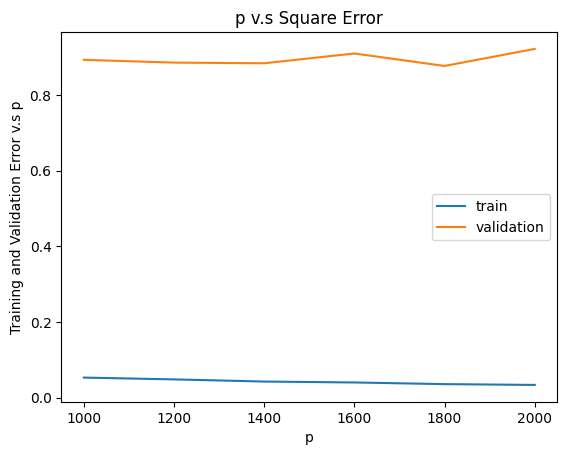

In [ ]:
print("Average Training Error:", sum(error_list[:,0])/len(error_list[:,0]))
print("Average Validation Error:", sum(error_list[:,1])/len(error_list[:,1]))

plt.plot(p_list, error_list[:,])
plt.xlabel("p")
plt.ylabel("Training and Validation Error v.s p")
plt.title("p v.s Square Error")
plt.legend(['train','validation'])
plt.show()

# Your solution:

Our training error was decreased by a large amount, but the validation error is very high, which is likely to do with the randomness of the transform being less uniform for the data that our model isn't trained for.

NOTE: I only ran 7 different $p$-values for the sake of time. Any $p \ge 3000$ took an extraordinarily long time to compute. My runtime for $p=6000$ was nearly 8 minutes and I almost ran out of memory. The validation error for $p=6000$ was also very large.



---


## Q2.5 Confidence Interval (5pt)
Instead of reporting just the test error, which is an unbiased estimate of the true error, we
would like to report a confidence interval around the test error that contains the true error.

**Lemma**: (Hoeffding’s inequality) Fix $\delta\in(0,1)$, if for all $i=1,\dots, m$ we have that $X_i$ are i.i.d. random variables with $X_i\in [a,b]$ and $\mathbb{E}[X_i]=\mu$ then
\begin{align}
\mathbb{P}\left(\left|\left(\frac{1}{m}\sum_{i=1}^m X_i\right)-\mu\right|\ge \sqrt{\frac{(b-a)^2\log(2/\delta)}{2m}}\right)\le \delta
\end{align}

We will use the above equation to construct a confidence interval around the true classification error $\mathcal{E}(\hat f)= \mathbb{E}_{\text{test}}[\hat{\mathcal{E}}_{\text{test}}(\hat f)]$ since the test error $\hat{\mathcal{E}}_{\text{test}}(\hat f)$ is just the average of indicator variables taking values in $\{0,1\}$ corresponding to the $i$-th test example being classified correctly or not, respectively, where an error happens with probability $\mathcal{E}(\hat f)= \mathbb{E}_{\text{test}}[\hat{\mathcal{E}}_{\text{test}}(\hat f)]$ the true classification error.

Let $\hat p$ be the value of $p$ that approximately minimizes the validation error on the plot you just made
and use $\hat f(x) = \arg\max_j x^\top \hat{\mathbf{W}}^{\hat p}e_j$ to compute the classification test error $\hat{\mathcal{E}}_{\text{test}}(\hat f)$. Use Hoeffding’s
inequality, to compute a confidence interval of $\hat{\mathcal{E}}_{\text{test}}(\hat f)$ that contains the true classification error $\mathbb{E}_{\text{test}}[\hat{\mathcal{E}}_{\text{test}}(\hat f)]$ with probability at least 0.95 (i.e., $\delta=0.05$).   

# Your solution:
The minimizer $p$ for the validation error was $p=1800$. Then, by considering a Bernoulli with respect to $p$, with $a=0, b=1, \delta = .05$ and applying Hoeffding's Inequality, we get:

\begin{align}
\mathbb{P}\left(\left|\bar{X}-\mu\right|\ge \sqrt{\frac{(b-a)^2\log(2/\delta)}{2m}}\right)\le \delta\\
\mathbb{P}\left(\left|\bar{X}-p\right|\ge \sqrt{\frac{\log(40)}{2m}}\right)\le .05\\
\mathbb{P}\left(\left|\bar{X}-p\right|\ge \sqrt{\frac{\log(40)}{2m}}\right) \ge .95\\
\mathbb{P}\left(-\sqrt{\frac{\log(40)}{2m}}\ge \bar{X}-p \ge \sqrt{\frac{\log(40)}{2m}}\right)\le .05\\
\mathbb{P}\left(\bar{X}-\sqrt{\frac{\log(40)}{2m}}\le p \le \bar{X} + \sqrt{\frac{\log(40)}{2m}}\right) \ge .95\\
\mathbb{P}\left(\bar{X}-\frac{1.358}{\sqrt{m}}\le p \le \bar{X} + \frac{1.358}{\sqrt{m}}\right) \ge .95\\
\end{align}

where $m$ is the number of iid random variables $X_i, i \in [1,m]$. Clearly, for higher values of $p$ (like what we have in this problem), we need our $\bar{X}$ to be within fairly close distance to $p$ to ensure the true error is within the confidence interval.



---



---



# Q3: USA Crime data (40pt)

### Data Set Description
The following data consist of local crime statistics for 1994 US communities. We have split the dataset into a training and testing set with 1595 and 399 entries, respectively. We’d like to use
this training set to fit a model to predict the crime rate in new communities and evaluate model performance on
the test set. As there are a considerable number of input variables and fairly few training datapoints, overfitting
is a serious issue. In order to avoid this, use the **stochastic coordinate descent LASSO algorithm**.

The response $y$ is the rate of violent crimes
reported per capita in a community. The name of the response variable is `ViolentCrimesPerPop`, and it is held
in the first column of `df_train` and `df_test`. There are 95 features. These features include many variables.
Some features are the consequence of complex political processes. Others
are demographic characteristics of the community, including self-reported statistics about race, age, education,
and employment drawn from Census reports. You may read the documentation for the original version of this dataset: http://archive.ics.uci.edu/ml/datasets/communities+and+crime. For example, `PctYoungKids2Par` represents percent of kids 4 and under in two parent households (numeric - decimal).

 Note **the features have been standardized to have mean 0 and variance 1**.

The goals of this problem are twofold:
- Think deeply about models you might train and
how they might be misused.

- See how Lasso encourages sparsity of linear models in settings where
the feature set is very large relative to the number of training examples.

We emphasize that training a
model on this dataset can suggest a degree of correlation between a community’s demographics
and the rate at which a community experiences and reports violent crime. We strongly encourage
you to consider why these correlations may or may not hold more generally, whether correlations might
result from a common cause, and what issues can result in misinterpreting what a model can explain.


In [ ]:
!wget https://raw.githubusercontent.com/yexf308/AppliedStatistics/main/Homework/HW3/crime-train.txt?raw=true -O crime-train.txt
!wget https://raw.githubusercontent.com/yexf308/AppliedStatistics/main/Homework/HW3/crime-test.txt?raw=true -O crime-test.txt

--2024-09-19 20:54:37--  https://raw.githubusercontent.com/yexf308/AppliedStatistics/main/Homework/HW3/crime-train.txt?raw=true
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 855572 (836K) [text/plain]
Saving to: ‘crime-train.txt’

crime-train.txt     100%[===================>] 835.52K  --.-KB/s    in 0.05s   

2024-09-19 20:54:37 (14.8 MB/s) - ‘crime-train.txt’ saved [855572/855572]

--2024-09-19 20:54:37--  https://raw.githubusercontent.com/yexf308/AppliedStatistics/main/Homework/HW3/crime-test.txt?raw=true
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting

In [ ]:
df_train = pd.read_table("crime-train.txt")
df_test = pd.read_table("crime-test.txt")

In [ ]:
a1=df_train.columns.get_loc('agePct12t29')
a2=df_train.columns.get_loc('pctWSocSec')
a3=df_train.columns.get_loc('pctUrban')
a4=df_train.columns.get_loc('agePct65up')
a5=df_train.columns.get_loc('householdsize')



---


## Q3.1: Stochastic coordinate descent LASSO algorithm (10pt)
In class, we introduce the coordinate descent LASSO algorithm in the round robin way. We can also pick the coordinate randomly.

**Algorithm:** To minimize function $\ell(\mathbf{w})$

Initialize $\hat{\mathbf{w}}=0$ or smartly
  - Precompute for all coordiate j
     $$ a_j = \mathbf{X}_j^\top \mathbf{X}_j $$
  - While not converged
   - Pick a coodinate j **uniformly at random**, compute

     \begin{align}
     & c_j = \mathbf{X}_j^\top (\mathbf{y}-\mathbf{X}_{-j}\mathbf{w}_{-j}) \\
     & \hat{w}_j = \text{SoftThreshold}\left(\frac{c_j}{a_j},\frac{\lambda}{a_j}\right)
     \end{align}

Modify the LASSO code in class to stochastic coordinate descent LASSO algorithm.      

In [ ]:
def SCD_Lasso_inefficient(X, y, lam=30, timer=False, tol=1e-6):

    """
    The Lasso Regression model
    Stochastic coordinate descent with co-variance updates is applied.

    X - NumPy matrix, size (N, d), of standardized numerical predictors, note the first column is ones.
    y - NumPy array, length N, of numerical response.
    lam - L1 penalty tuning parameter (positive scalar)
    tol - Coordinate Descent convergence tolerance (exited if change < tol)

    """
    d = X.shape[1]
    w_s = np.zeros(d)
    iter = 0
    #convert pandas array to numpy
    val = pd.DataFrame(X).to_numpy()
    a = np.zeros(d)
    index = []
    for j in range(d):
        a[j] = sum(val[:,j]**2)
        index.append(list(range(0,j)) + list(range(j+1,d)))

    # establish list of index's of size d
    rand_list = list(range(0,d))

    while True:
        w_pre = w_s.copy()
        # pick a random index from the list, set equal to j. after picking, we can remove j from the list so we can't get it again (if desired)
        j = rand.choice(rand_list)
        rand_list.remove(j)

        # find c_j, update and w_s with random j
        c_j = np.dot(val[:,j].T, y-np.dot(val[:,index[j]],w_s[index[j]])) # this is not optimal, try to optimize as much as possible.
        update = c_j/a[j]

        w_s[j] = np.sign(update) * max(abs(update) - lam/a[j], 0)

        iter = iter + 1
        if np.all(abs(w_s-w_pre)<tol) or len(rand_list) == 0:
            break
    if timer:
        return iter
    else:
        return w_s

X = df_train.drop('ViolentCrimesPerPop', axis=1)
y = df_train['ViolentCrimesPerPop']
# print(X.shape, y.shape)

X_test = df_test.drop('ViolentCrimesPerPop', axis=1)
y_test = df_test['ViolentCrimesPerPop']

print(SCD_Lasso_inefficient(X,y))


[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.090115    0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.06325571  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         



---


## Q3.2  Efficient LASSO Algorithm (10pt)
In fact, the current code is not efficient since it recalculate the same thing again and again in each iteration, which waste a lot of computational power. Please optimize your code, particularly in calculating `c_j` and `update`. Make sure test the correctness and efficiency in your new code.

In [ ]:
def SCD_Lasso(X, y, lam, w_s, timer=False, tol=1e-6):

    """
    The Lasso Regression model
    Stochastic coordinate descent with co-variance updates is applied.

    X - NumPy matrix, size (N, d), of standardized numerical predictors, note the first column is ones.
    y - NumPy array, length N, of numerical response.
    lam - L1 penalty tuning parameter (positive scalar)
    tol - Coordinate Descent convergence tolerance (exited if change < tol)

    """
    d = X.shape[1]
    iter = 0
    #convert pandas array to numpy
    val = pd.DataFrame(X).to_numpy()
    a = np.zeros(d)
    index = []
    for j in range(d):
        a[j] = sum(val[:,j]**2)
        index.append(list(range(0,j)) + list(range(j+1,d)))

    # establish list of index's of size d
    rand_list = list(range(0,d))

    while True:
        w_pre = w_s.copy()
        # pick a random index from the list, set equal to j. after picking, we can remove j from the list so we can't get it again (if desired)
        j = rand.choice(rand_list)
        rand_list.remove(j)

        # my implimentation to make the code more efficient
        temp1 = np.dot(val[:,j].T, y)
        temp2 = np.dot(np.dot(val[:,j],val[:,index[j]]), w_s[index[j]])
        c_j = temp1-temp2

        update = c_j/a[j]
        w_s[j] = np.sign(update) * max(abs(update) - lam/a[j], 0)

        iter = iter + 1
        # or statement for j removal to ensure no error with length == 0
        if np.all(abs(w_s-w_pre)<tol) or len(rand_list) == 0:
            break
    # choosing between the monte carlo (for speed analysis) and returning w_s (for the purpose of the function)

    if timer:
        return iter
    else:
        return w_s

X = df_train.drop('ViolentCrimesPerPop', axis=1)
y = df_train['ViolentCrimesPerPop']
# print(X.shape, y.shape)

X_test = df_test.drop('ViolentCrimesPerPop', axis=1)
y_test = df_test['ViolentCrimesPerPop']


In [ ]:
def compare_c_j(X, y, lam, w_s, timer=False, tol=1e-6):

    d = X.shape[1]
    w_s_old = np.zeros(d)
    iter = 0
    #convert pandas array to numpy
    val = pd.DataFrame(X).to_numpy()
    a = np.zeros(d)
    index = []
    for j in range(d):
        a[j] = sum(val[:,j]**2)
        index.append(list(range(0,j)) + list(range(j+1,d)))

    # establish list of index's of size d
    rand_list = list(range(0,d))

    while True:
        w_pre_old = w_s_old.copy()
        w_pre = w_s.copy()
        # pick a random index from the list, set equal to j. after picking, we can remove j from the list so we can't get it again (if desired)
        j = rand.choice(rand_list)
        rand_list.remove(j)

        # old
        c_j_old = np.dot(val[:,j].T, y-np.dot(val[:,index[j]],w_s_old[index[j]]))
        update = c_j_old/a[j]
        w_s_old[j] = np.sign(update) * max(abs(update) - lam/a[j], 0)

        # my implimentation to make the code more efficient
        temp1 = np.dot(val[:,j].T, y)
        temp2 = val[:,j] @ val[:,index[j]]
        temp3 = np.dot(temp2, w_s[index[j]])
        c_j = temp1-temp3
        update = c_j/a[j]
        w_s[j] = np.sign(update) * max(abs(update) - lam/a[j], 0)

        iter = iter + 1
        # or statement for j removal to ensure no error with length == 0
        print("difference c_j_ineff - c_j, rounded to e-9:", np.round(c_j_old - c_j, 9))
        if np.all(abs(w_s_old-w_pre_old)<tol) or len(rand_list) == 0:
            break
    # choosing between the monte carlo (for speed analysis) and returning w_s (for the purpose of the function)


# Monte Carlo for iteration average and time

# inefficient
lamb = 5
loops = 10
bind = 0
iteration_count = 0

start_time = time.time()
while bind < loops:
    iteration_count += SCD_Lasso_inefficient(X,y,lamb,timer=True)
    bind+=1

print("avg iterations:", iteration_count/loops)
print("--- %s seconds ---" % (time.time() - start_time))

# efficient
w = np.zeros(X.shape[1])
bind = 0
iteration_count = 0

start_time = time.time()
while bind < loops:
    iteration_count += SCD_Lasso(X,y,lamb,w,timer=True)
    bind+=1

print("avg iterations:", iteration_count/loops)
print("--- %s seconds ---" % (time.time() - start_time))


#accuracy
compare_c_j(X, y, 5, np.zeros(X.shape[1]))

avg iterations: 10.9
--- 0.22430801391601562 seconds ---
avg iterations: 8.2
--- 0.09274888038635254 seconds ---
difference c_j_ineff - c_j, rounded to e-9: 0.0
difference c_j_ineff - c_j, rounded to e-9: 0.0
difference c_j_ineff - c_j, rounded to e-9: -0.0
difference c_j_ineff - c_j, rounded to e-9: 0.0
difference c_j_ineff - c_j, rounded to e-9: -0.0
difference c_j_ineff - c_j, rounded to e-9: -0.0
difference c_j_ineff - c_j, rounded to e-9: 0.0


# Your Solution:

To make the code above more efficient, I simply recognized that:

$$
\begin{align*}
X^T_j(y-X_{-j} * w^s_{-j}) &= X^T_j*y- X^T_j * (X_{-j} * w^s_{-j})\\
&= X^T_j*y - (X^T_j * X_{-j}) * w^s_{-j}
\end{align*}
$$

This reduces a large number of matrix operations from $y-X_{-j} * w^s_{-j}$ by making two scalars from $X^T_j*y$ and $(X^T_j * X_{-j}) * w^s_{-j}$. This simple change shaved off roughly 10 seconds from the Monte Carlo simulation running the code 1000 times at $\lambda = 1$.

Further changes could go towards figuring out a way to make the $X^T_j * X_{-j}$ term more efficient since there is a bit of overlap in a lot of the iterations, but with the addition of having the changing $w^s_{-j}$ vector every interation, I didn't find much worth in investigating further, especially when my main code below runs entirely through in < 1 second.



---


## Q3.3: Training (20pt)
- We will run the LASSO solver with $\lambda=\lambda_{\max}$ defined above.
- For the initial weights, just use 0. Then, cut
$\lambda$ down by a factor of 2 and run again, but this time pass in the values of $\hat{\mathbf w}$ from your $\lambda=\lambda_{\max}$ solution as
your initial weights. This is faster than initializing with 0 weights each time.(You need to modify LASSO function accordingly, e.g., you can let initial weights as your input.)

- Continue the process of cutting $\lambda$ by a factor of 2 until the smallest value of $\lambda$ is less than 0.01. Define “converging” as the change in any coefficient between one iteration and the next is no larger than $10^{-6}$.



For all plots use a log-scale for $\lambda$. You use `plt.xscale('log')`.
- Plot the number of nonzeros of each solution versus $\lambda$.

- Plot the regularization paths (in one plot) for the coefficients for input features `agePct12t29`,
`pctWSocSec`, `pctUrban`, `agePct65up`, and `householdsize`.

- On one plot, plot the squared error on the training and test data versus $\lambda$.

- Sometimes a larger value of $\lambda$ performs nearly as well as a smaller value, but a larger value will
select fewer variables and perhaps be more interpretable. Inspect the weights (on features) for $\lambda=30$.
Which feature variable had the largest (most positive) Lasso coefficient? What about the most negative?
Discuss briefly.


In [ ]:
# retrieves the number of non-zero entries in a list
def nonzero_count(l):
    s = 0
    for i in l:
        if i !=0:
            s+=1
    return s

# retrieves mse_train and mse_test for a given w
def squared_error(X_train, Y_train, X_test, Y_test, w):
    x_train = pd.DataFrame(X_train).to_numpy()
    y_train = pd.DataFrame(Y_train).to_numpy()
    x_test = pd.DataFrame(X_test).to_numpy()
    y_test = pd.DataFrame(Y_test).to_numpy()

    y_hat_train = np.dot(x_train, w)
    y_hat_test = np.dot(x_test, w)

    mse_train = np.square(np.subtract(y_hat_train, y_train))
    mse_test = np.square(np.subtract(y_hat_test, y_test))
    return [np.round(sum(mse_train)/len(mse_train),1), np.round(sum(mse_test)/len(mse_test),1)]


# getting the indices of the features we wish to look at
a1 = df_train.columns.get_loc('agePct12t29')
a2 = df_train.columns.get_loc('pctWSocSec')
a3 = df_train.columns.get_loc('pctUrban')
a4 = df_train.columns.get_loc('agePct65up')
a5 = df_train.columns.get_loc('householdsize')

'''
# initialization of lambda max and the first w_s with lambda max
max_op = X.T @ y
# the value for lamb_max is here, but for the analysis at lamb=30, I set lamb_max to a value that would hit 30 evenly
lamb_max = 2 * np.linalg.norm(max_op, np.inf)
'''
lamb_max = 480
w_init = np.zeros(X.shape[1])
w_iter = SCD_Lasso(X, y, lamb_max, w_init)

# capturing data of the lambda, nonzero_count of w found with that lambda
# the coefficients of the 5 features we care about iteratively
# and the mse for the training and testing data for that w
lambdas = [np.round(lamb_max, 6)]
nonzeros = [nonzero_count(w_init)]
features = [[w_init[a1], w_init[a2], w_init[a3], w_init[a4], w_init[a5]]]
mse = [squared_error(X,y,X_test,y_test,w_init)]

lamb = lamb_max/2
# gathering the data for the lambdas and
while lamb > .01:
    w_temp = SCD_Lasso(X,y,lamb,w_iter)
    lambdas.append(np.round(lamb, 6))
    nonzeros.append(nonzero_count(w_temp))
    features.append([w_temp[a1], w_temp[a2], w_temp[a3], w_temp[a4], w_temp[a5]])
    mse.append(squared_error(X,y,X_test,y_test,w_iter))
    w_iter = w_temp
    lamb = lamb/2

features = np.asarray(features)
mse = np.asarray(mse)


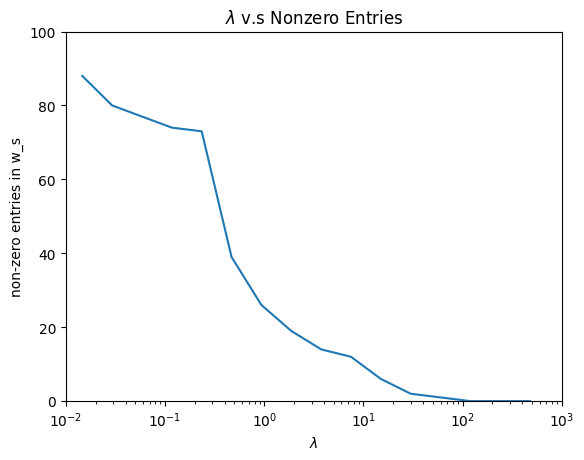

In [ ]:
plt.plot(lambdas, nonzeros)
plt.xscale('log')
plt.xlabel("$\lambda$")
plt.ylabel("non-zero entries in w_s")
plt.title("$\lambda$ v.s Nonzero Entries")
plt.axis([.01,1000,0,100])
plt.show()

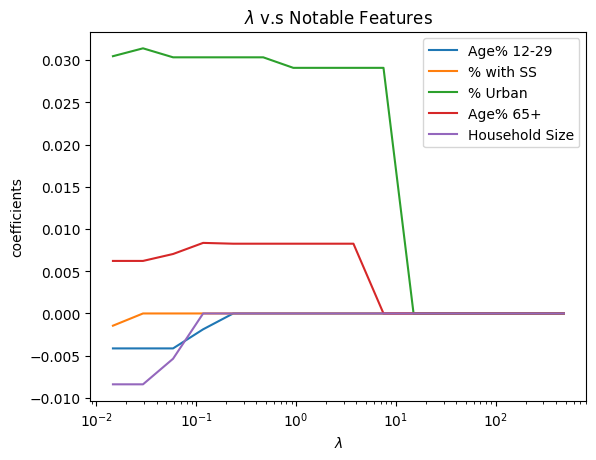

In [ ]:
plt.plot(lambdas, features[:,])
plt.xscale('log')
plt.xlabel("$\lambda$")
plt.ylabel("coefficients")
plt.title("$\lambda$ v.s Notable Features")
plt.legend(['Age% 12-29','% with SS','% Urban','Age% 65+','Household Size'])

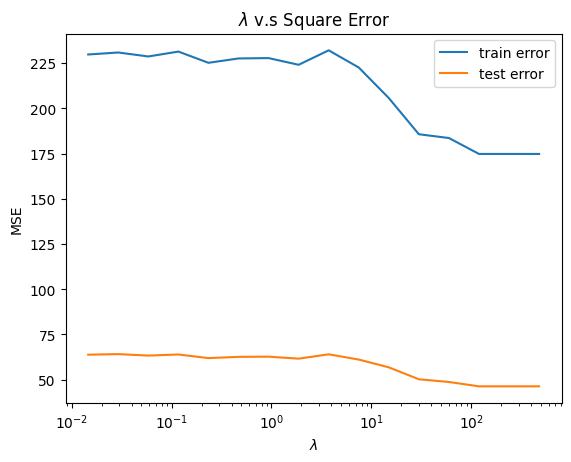

In [ ]:
plt.plot(lambdas, mse[:,])
plt.xscale('log')
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
plt.title("$\lambda$ v.s Square Error")
plt.legend(['train error','test error'])

In [ ]:
w = np.zeros(X.shape[1])
w_30 = SCD_Lasso(X,y,30,w)

max_coef = 0
max_index = 0
min_coef = 0
min_index = 0

for i in range(len(w_30)):
    if w_30[i] > max_coef:
        max_coef = w_30[i]
        max_index = i
    elif w_30[i] < min_coef:
        min_coef = w_30[i]
        min_index = i

print(df_train.columns[max_index], max_coef)
print(df_train.columns[min_index], min_coef)

PctHousNoPhone 0.07265841784814822
PctNotHSGrad -0.02998512286916146


# Your Solution:

From the randomness of the SCD lasso, it's hard to get a distinguished result from the max/min coefficients of the lasso as it's different every time, at least for a relatively large $\lambda$. We can conclude that a lower $\lambda$ would be more suitable for this particular data using SCD lasso.